In [ ]:
import pandas as pd
from google.colab import files
uploaded=files.upload()

Saving adult.csv to adult (1).csv


In [ ]:
import io
import numpy as np
from collections import Counter
import numpy as np
df=pd.read_csv(io.BytesIO(uploaded['adult.csv']))
df.columns =['age', 'workclass', 'fnlwgt', 'education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
print(df.head())

   age          workclass  fnlwgt   education  education-num  \
0   50   Self-emp-not-inc   83311   Bachelors             13   
1   38            Private  215646     HS-grad              9   
2   53            Private  234721        11th              7   
3   28            Private  338409   Bachelors             13   
4   37            Private  284582     Masters             14   

        marital-status          occupation    relationship    race      sex  \
0   Married-civ-spouse     Exec-managerial         Husband   White     Male   
1             Divorced   Handlers-cleaners   Not-in-family   White     Male   
2   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
3   Married-civ-spouse      Prof-specialty            Wife   Black   Female   
4   Married-civ-spouse     Exec-managerial            Wife   White   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0             0             0              13   United-States   <=50

1. Implement the decision tree algorithm to classify whether the income of a particular user exceeds $50K per year or not.
Divide the data into two sets: Training set (80%) and validation set (20%). Plot the training error and validation error
against the number of nodes present in the decision tree. Describe the optimal decision tree in your video.

In [ ]:
df = df[(df.astype(str) != ' ?').all(axis=1)]
df['income_bi'] = df.apply(lambda row: 1 if '>50K'in row['income'] else 0, axis=1)
df = df.drop(['income','fnlwgt','capital-gain','capital-loss','native-country'], axis=1)
df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

In [ ]:
df = df.sample(frac=1)
d_train = df[:25000]
d_test = df[25000:]
X_train = d_train.drop(['income_bi'], axis=1)
y_train = d_train['income_bi']
X_test = d_test.drop(['income_bi'], axis=1)
y_test = d_test['income_bi']

In [ ]:
def entropy(y):
  a=(y.value_counts()/y.shape[0])
  entropy=np.sum(-a*(np.log2(a+1e-9)))
  return entropy

In [ ]:
def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred) / len(y_true)
  return accuracy

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        if (self.value is not None):
          return True
        else:
          return False

In [ ]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def predict(self, X):
        li=[]
        for x in X.index:
          li.append(self._traverse_tree(X.loc[x], self.root))
        return np.array(li)

    def fit(self, X, y):
        if self.n_feats:
          self.n_feats=min(self.n_feats,X.shape[1]) 
        else:
          self.n_feats=X.shape[1]
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            counter = Counter(y)
            leaf_value = counter.most_common(1)[0][0]
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X.iloc[:, best_feat], best_thresh)

        left = self._grow_tree(X.iloc[left_idxs, :], y.iloc[left_idxs], depth + 1)
        right = self._grow_tree(X.iloc[right_idxs, :], y.iloc[right_idxs], depth + 1)

        return Node(best_feat, best_thresh, left, right)

    def _split(self, X_column, split_thresh):
        right_idxs = np.argwhere(X_column.to_numpy() > split_thresh)
        right_idxs = right_idxs.flatten()
        left_idxs = np.argwhere(X_column.to_numpy() <= split_thresh)
        left_idxs = left_idxs.flatten()
        return left_idxs, right_idxs

    def _information_gain(self, y, X_column, split_thresh):
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l = len(left_idxs) 
        n_r = len(right_idxs)
        e_l= entropy(y.iloc[left_idxs]) 
        e_r= entropy(y.iloc[right_idxs])
        ig = entropy(y) - ((n_l / n) * e_l + (n_r / n) * e_r)
        return ig

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] > node.threshold:
            return self._traverse_tree(x, node.right)
        return self._traverse_tree(x, node.left)
    
    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X.iloc[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

In [ ]:
nodes=[]
v_mse=[]
t_mse=[]
accur=[]
for i in range(2,11):
  clf = DecisionTree(max_depth=i)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  valid_mse=np.square(np.subtract(y_test,y_pred)).mean()
  y_train_pred = clf.predict(X_train)
  train_mse=np.square(np.subtract(y_train,y_train_pred)).mean()
  acc = accuracy(y_test, y_pred)
  print("Accuracy:", acc)
  nodes.append((2**i)-1)
  v_mse.append(valid_mse)
  t_mse.append(train_mse)
  accur.append(acc)

Accuracy: 0.8176709939934121
Accuracy: 0.8176709939934121
Accuracy: 0.818639798488665
Accuracy: 0.8203836465801201
Accuracy: 0.8285216043402441
Accuracy: 0.8341406704127107
Accuracy: 0.8331718659174578
Accuracy: 0.8327843441193568
Accuracy: 0.832203061422205


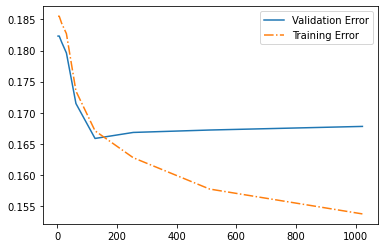

In [ ]:
import matplotlib.pyplot as plt
plt.plot(nodes,v_mse,label="Validation Error")
plt.plot(nodes,t_mse,'-.',label="Training Error")
plt.legend()
plt.show()

2. Create 10 datasets using bootstrap technique and rerun the part 1 to find the optimal decision tree for each of these
datasets. Report the final error by taking the average of each decision tree and report your findings. Did the performance
improved?

In [ ]:
df=df.reset_index()

In [ ]:
from random import seed
from random import randrange
def train_test_split(dataset,split):
  valid_size=split*len(dataset)
  dataset_copy=dataset.copy()
  valid=dataset_copy.sample(frac=split)
  return valid

In [ ]:
seed(1)
v_mse=[]
t_mse=[]
accur=[]
for i in range(10):
  valid=train_test_split(df,0.20)
  X_train = valid.drop(['income_bi'], axis=1)
  y_train = valid['income_bi']
  clf = DecisionTree(max_depth=i)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_train)
  valid_mse=np.square(np.subtract(y_train,y_pred)).mean()
  print("Dataset=",i)
  v_mse.append(valid_mse)

Dataset= 0
Dataset= 1
Dataset= 2
Dataset= 3
Dataset= 4
Dataset= 5
Dataset= 6
Dataset= 7
Dataset= 8
Dataset= 9


In [ ]:
mean_error=np.mean(v_mse)
print(mean_error)

0.18431697612732095


Yes the performance has improved

3. Implement PCA to find optimal number of features. Plot the error of optimal decision tree against the number of features.
How many features did it require to match the performance of the tree obtained in the first part.

In [ ]:
#PCA
df1 = df.copy()
df1=df1.drop(['income_bi'], axis=1)
print(df1.shape)

(30161, 61)


In [ ]:
from sklearn.preprocessing import StandardScaler
X_std=StandardScaler().fit_transform(df1)

In [ ]:
X_covariance_matrix=np.cov(X_std.T)

In [ ]:
eig_vals,eig_vecs=np.linalg.eig(X_covariance_matrix)

In [ ]:
eig_pairs=[(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0],reverse=True)

In [ ]:
tot=sum(eig_vals)
var_exp=[(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp=np.cumsum(var_exp)

In [ ]:
features=2
matrix_w=np.hstack((eig_pairs[0][1].reshape(61,1),eig_pairs[1][1].reshape(61,1)))
Y=X_std.dot(matrix_w)
print(Y.shape)

(30161, 2)


In [ ]:
y=df["income_bi"]
print(y.shape)
errors=[]
features_count=[]

(30161,)


In [ ]:
X_train=pd.DataFrame(data=Y)
y_train=y
clf = DecisionTree(max_depth=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
valid_mse=np.square(np.subtract(y_train,y_pred)).mean()

In [ ]:
print(valid_mse)
errors.append(valid_mse)
features_count.append(features)

0.17990119690991677


In [ ]:
features=3
matrix_w=np.hstack((eig_pairs[0][1].reshape(61,1),eig_pairs[1][1].reshape(61,1),eig_pairs[2][1].reshape(61,1)))
Y=X_std.dot(matrix_w)
print(Y.shape)

(30161, 3)


In [ ]:
X_train=pd.DataFrame(data=Y)
y_train=y
clf = DecisionTree(max_depth=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
valid_mse=np.square(np.subtract(y_train,y_pred)).mean()

In [ ]:
print(valid_mse)
errors.append(valid_mse)
features_count.append(features)

0.17476211000961506


In [ ]:
features=4
matrix_w=np.hstack((eig_pairs[0][1].reshape(61,1),eig_pairs[1][1].reshape(61,1),eig_pairs[2][1].reshape(61,1),eig_pairs[3][1].reshape(61,1)))
Y=X_std.dot(matrix_w)
print(Y.shape)

(30161, 4)


In [ ]:
X_train=pd.DataFrame(data=Y)
y_train=y
clf = DecisionTree(max_depth=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
valid_mse=np.square(np.subtract(y_train,y_pred)).mean()

In [ ]:
print(valid_mse)
errors.append(valid_mse)
features_count.append(features)

0.17114817147972547


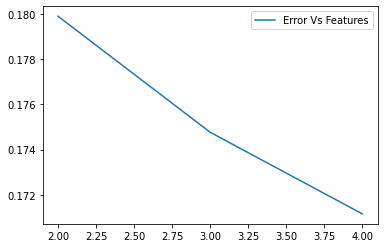

In [ ]:
import matplotlib.pyplot as plt
plt.plot(features_count,errors,label="Error Vs Features")
plt.legend()
plt.show()

Therefor it requires 4 features to match the performance of above implementation when depth is taken as 7.